# Proyecto 03 - Series de Tiempo

## Dataset: Flujo Vehicular por Unidades de Peaje AUSA

**Recuerda descargar el dataset de [aquí](https://data.buenosaires.gob.ar/dataset/flujo-vehicular-por-unidades-peaje-ausa). Deberás descargar -  al menos para comenzar - los años 2017, 2018 y 2019.**

En este notebook te dejamos unas celdas para que puedas comenzar a trabajar con este dataset para los años 2017, 2018 y 2019. Si deseas utilizar otros años, ten en cuenta que deberás hacer el preprocesamiento correspondiente, ya que la estructura de los datos puede variar.

**Importante:** Para el proyecto, debes comenzar con los datos de la autopista Illia, pago en Efectivo.

### Exploración de datos

Dedícale un buen tiempo a hacer un Análisis Exploratorio de Datos. Elige preguntas que creas que puedas responder con este dataset. Por ejemplo, ¿Cuáles son los días y horarios de mayor tráfico? También, estudia autocorrelaciones, resampleos, etc.

#### Componentes de la serie

1. Calcula las componentes estacionales y tendencia de la serie. Interpreta los resultados, si es necesario con información auxiliar (por fuera del dataset) o elementos del dataset que no estés utilizando (por ejemplo, si la tendencia es negativa, ¿puede ser porque se migre a otras formas de pago?).
1. ¿La serie posee valores atípicos? Si es así, interpreta, si es necesario con información auxiliar. **Pista**: primer semestre 2019.

### Predicción a Futuro

Debes implementar un modelo que prediga el tráfico en la autopista Illia para el último trimestre del 2019. 

1. Haz todas las transformaciones de datos que consideres necesarias. Justifica.
1. Evalúa de forma apropiada tus resultados. Justifica la métrica elegida.
1. Elige un modelo benchmark y compara tus resultados con este modelo.
1. Optimiza los hiperparámetros de tu modelo. 
1. Intenta responder la pregunta: ¿Qué información está usando el modelo para predecir?
1. Utiliza el modelo creado para predecir el tráfico en el año 2020. ¿Cómo funciona?
1. Si lo deseas, puedes agregar información de años anteriores a 2017. ¿Mejoran los resultados?

### Para pensar, investigar y, opcionalmente, implementar
1. ¿Cómo incorporarías la información sobre tipo de vehículo, forma de pago, sentido, día de la semana, etc.? En lo que respecta a las predicciones, ¿mejoran o empeoran?
1. ¿Qué ocurre si comparas las series de tiempo entre distintas estaciones de peajes?¿Tienen el mismo comportamiento o hay alguna que sea distinta a las otras? Si es así, ¿hay información auxiliar que te ayude a explicar lo que encuentras?
1. ¿Hay algo que te gustaría investigar o probar?

### **¡Tómate tiempo para investigar y leer mucho!**


## Preparación del Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

from sklearn.metrics import mean_absolute_error

from xgboost import XGBRegressor
from xgboost import plot_importance

In [2]:
data_2019 = pd.read_csv('Datasets//flujo-vehicular-2019.csv', sep =',')
data_2018 = pd.read_csv('Datasets//flujo-vehicular-2018.csv', sep =',')
data_2017 = pd.read_csv('Datasets//flujo-vehicular-2017.csv', sep =',')

In [3]:
data_2019.info()
data_2019.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 812153 entries, 0 to 812152
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   periodo         812153 non-null  int64 
 1   fecha           812153 non-null  object
 2   hora_inicio     812153 non-null  int64 
 3   hora_fin        812153 non-null  int64 
 4   dia             812153 non-null  object
 5   estacion        812153 non-null  object
 6   sentido         812153 non-null  object
 7   tipo_vehiculo   812153 non-null  object
 8   forma_pago      812153 non-null  object
 9   cantidad_pasos  812153 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 62.0+ MB


,periodo,fecha,hora_inicio,hora_fin,dia,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos
0,2019,2019-01-01,0,1,Martes,Alberti,Centro,Liviano,NO COBRADO,22
1,2019,2019-01-01,0,1,Martes,Alberti,Centro,Liviano,TELEPASE,6
2,2019,2019-01-01,0,1,Martes,Alberti,Provincia,Liviano,NO COBRADO,53
3,2019,2019-01-01,0,1,Martes,Alberti,Provincia,Liviano,TELEPASE,18
4,2019,2019-01-01,0,1,Martes,Avellaneda,Centro,Liviano,EFECTIVO,16


In [4]:
data_2018.info()
data_2018.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1375908 entries, 0 to 1375907
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   periodo         1375908 non-null  int64 
 1   fecha           1375908 non-null  object
 2   hora_inicio     1375908 non-null  int64 
 3   hora_fin        1375908 non-null  int64 
 4   dia             1375908 non-null  object
 5   estacion        1375908 non-null  object
 6   sentido         1375908 non-null  object
 7   tipo_vehiculo   1375908 non-null  object
 8   forma_pago      1375908 non-null  object
 9   cantidad_pasos  1375908 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 105.0+ MB


,periodo,fecha,hora_inicio,hora_fin,dia,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos
0,2018,2018-01-01,0,1,Lunes,Alberdi,Centro,Liviano,NO COBRADO,29
1,2018,2018-01-01,0,1,Lunes,Alberdi,Centro,Liviano,TELEPASE,9
2,2018,2018-01-01,1,2,Lunes,Alberdi,Centro,Liviano,NO COBRADO,73
3,2018,2018-01-01,1,2,Lunes,Alberdi,Centro,Liviano,TELEPASE,39
4,2018,2018-01-01,2,3,Lunes,Alberdi,Centro,Liviano,NO COBRADO,115


In [5]:
data_2017.info()
data_2017.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1372645 entries, 0 to 1372644
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   periodo         1372645 non-null  int64 
 1   fecha           1372645 non-null  object
 2   hora_inicio     1372645 non-null  int64 
 3   hora_fin        1372645 non-null  int64 
 4   dia             1372645 non-null  object
 5   estacion        1372645 non-null  object
 6   sentido         1372645 non-null  object
 7   tipo_vehiculo   1372645 non-null  object
 8   forma_pago      1372645 non-null  object
 9   cantidad_pasos  1372645 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 104.7+ MB


,periodo,fecha,hora_inicio,hora_fin,dia,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos
0,2017,2017-01-01,0,1,Domingo,Alberdi,Centro,Liviano,NO COBRADO,25
1,2017,2017-01-01,0,1,Domingo,Alberdi,Centro,Liviano,TELEPASE,7
2,2017,2017-01-01,1,2,Domingo,Alberdi,Centro,Liviano,NO COBRADO,5
3,2017,2017-01-01,1,2,Domingo,Alberdi,Centro,Liviano,EFECTIVO,2
4,2017,2017-01-01,1,2,Domingo,Alberdi,Centro,Liviano,EFECTIVO,94


Investiguemos que valores toman los campos **estacion, sentido, tipo_vehiculo y forma_pago**

In [6]:
print(data_2019['estacion'].unique())
print(data_2018['estacion'].unique())
print(data_2017['estacion'].unique())

['Alberti' 'Avellaneda' 'Dellepiane' 'Illia' 'Retiro' 'Salguero'
 'Sarmiento' 'PDB']
['Alberdi' 'Avellaneda' 'Dellepiane Centro' 'Dellepiane Liniers' 'Illia'
 'Retiro' 'Salguero' 'Sarmiento']
['Alberdi' 'Avellaneda' 'Dellepiane Centro' 'Dellepiane Liniers' 'Illia'
 'Retiro' 'Salguero' 'Sarmiento']


In [7]:
print(data_2019['sentido'].unique())
print(data_2018['sentido'].unique())
print(data_2017['sentido'].unique())

['Centro' 'Provincia']
['Centro' 'Provincia']
['Centro' 'Provincia']


In [8]:
print(data_2019['tipo_vehiculo'].unique())
print(data_2018['tipo_vehiculo'].unique())
print(data_2017['tipo_vehiculo'].unique())

['Liviano' 'Pesado']
['Liviano' 'Pesado']
['Liviano' 'Pesado']


In [9]:
print(data_2019['forma_pago'].unique())
print(data_2018['forma_pago'].unique())
print(data_2017['forma_pago'].unique())

['NO COBRADO' 'TELEPASE' 'EFECTIVO' 'EXENTO' 'INFRACCION'
 'T. DISCAPACIDAD']
['NO COBRADO' 'TELEPASE' 'EFECTIVO' 'EXENTO' 'TARJETA DISCAPACIDAD'
 'INFRACCION']
['NO COBRADO' 'TELEPASE' 'EFECTIVO' 'TARJETA DISCAPACIDAD' 'EXENTO'
 'INFRACCION' 'MONEDERO' 'Otros']


##### Podemos decir entonces que los años 2017, 2018 y 2019 tienen las siguientes columnas con la siguiente información:

**periodo**: año del dset 

**fecha**: año dia mes

**hora_inicio** hora de inicio de la cuenta de vehiculos (DROP)

**hora_fin** hora de fin de la cuenta de vehiculos (Vamos a usar esta para tomar la hora)

**dia**: dia de la semana 

**estacion**: estaciones de peaje, difieren levemente entre los años (Dellepiane se unifica en 2019, antes habia Dellepiane Liniers y Centro, y se agrega PDB)

**sentido**: Centro o Provincia

**tipo_vehiculo**: Liviano o Pesado

**forma_pago**: Hay varias y varian entre los años.

**cantidad_pasos**: Cantidad de vehiculos

Vamos a estar trabajando con la estación **Illia** y la forma de pago **Efectivo**


In [10]:
#Unimos los 3 datasets, podemos hacerlo asi directamente ya que tienen las mismas columnas
dataset = pd.concat([data_2019, data_2018, data_2017])

#Nos quedamos solamente con la estación Illia y la forma de pago Efectivo
mask = np.logical_and(dataset.estacion=='Illia', dataset.forma_pago == 'EFECTIVO')
dataset = dataset[mask]

#Quitamos las columnas que no vamos a utilizar
dataset.drop(columns = ['periodo','hora_inicio','forma_pago', 'estacion'], inplace = True)

dataset.head()

,fecha,hora_fin,dia,sentido,tipo_vehiculo,cantidad_pasos
80,2019-01-01,2,Martes,Centro,Liviano,537
86,2019-01-01,2,Martes,Centro,Pesado,1
88,2019-01-01,2,Martes,Provincia,Liviano,443
94,2019-01-01,2,Martes,Provincia,Pesado,1
149,2019-01-01,3,Martes,Centro,Liviano,769


In [11]:
#Pasamos la columna fecha a formato datetime, y le unimos la hora_fin como hora
dataset['fecha2'] = pd.to_datetime(dataset.fecha) + pd.to_timedelta(dataset.hora_fin, unit = 'h')

#Quitamos las columnas fecha y hora_fin ya que las incluimos en el campo fecha2
dataset.drop(columns=['fecha','hora_fin'], inplace = True)

dataset.head()

,dia,sentido,tipo_vehiculo,cantidad_pasos,fecha2
80,Martes,Centro,Liviano,537,2019-01-01 02:00:00
86,Martes,Centro,Pesado,1,2019-01-01 02:00:00
88,Martes,Provincia,Liviano,443,2019-01-01 02:00:00
94,Martes,Provincia,Pesado,1,2019-01-01 02:00:00
149,Martes,Centro,Liviano,769,2019-01-01 03:00:00


In [12]:
#Corregimos el nombre de fecha2 a fecha
dataset.rename(columns = {'fecha2':'fecha'}, inplace = True) 
dataset.head()

,dia,sentido,tipo_vehiculo,cantidad_pasos,fecha
80,Martes,Centro,Liviano,537,2019-01-01 02:00:00
86,Martes,Centro,Pesado,1,2019-01-01 02:00:00
88,Martes,Provincia,Liviano,443,2019-01-01 02:00:00
94,Martes,Provincia,Pesado,1,2019-01-01 02:00:00
149,Martes,Centro,Liviano,769,2019-01-01 03:00:00


In [13]:
#Reordenamos el dataset por fecha
dataset.sort_values('fecha', inplace = True)
dataset.reset_index(drop=True, inplace = True)
dataset

,dia,sentido,tipo_vehiculo,cantidad_pasos,fecha
0,Domingo,Provincia,Pesado,1,2017-01-01 00:00:00
1,Domingo,Provincia,Liviano,9,2017-01-01 00:00:00
2,Domingo,Provincia,Liviano,644,2017-01-01 00:00:00
3,Domingo,Provincia,Pesado,6,2017-01-01 00:00:00
4,Domingo,Provincia,Pesado,1,2017-01-01 00:00:00
...,...,...,...,...,...
238864,Martes,Provincia,Liviano,556,2019-12-31 22:00:00
238865,Martes,Provincia,Pesado,1,2019-12-31 22:00:00
238866,Martes,Centro,Liviano,580,2019-12-31 22:00:00
238867,Martes,Centro,Liviano,214,2019-12-31 23:00:00


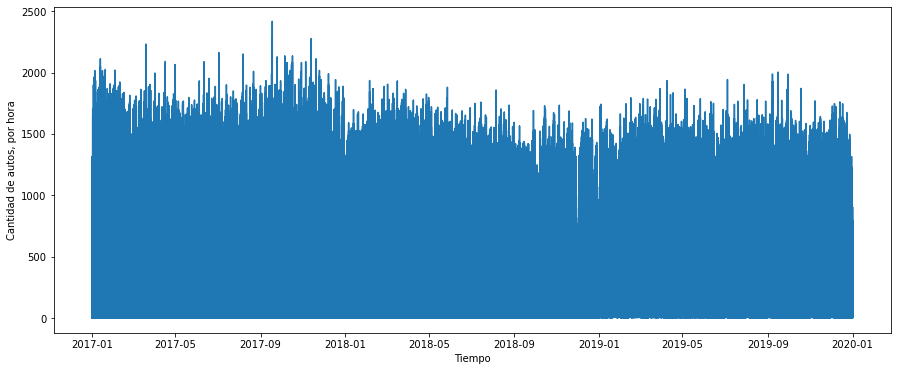

In [14]:
#Graficamos nuestros datos, tal como están
plt.figure(figsize = (15,6))
plt.plot(dataset.fecha, dataset.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por hora')
plt.show()

In [15]:
#Resampleamos nuestros datos para agrupar por dia, y asi tal vez lograr una visualización mas amigable
diario = dataset.resample('D', on = 'fecha').sum()
print(diario.shape)
diario.head()

(1095, 1)


,cantidad_pasos
fecha,
2017-01-01,31183
2017-01-02,51568
2017-01-03,51093
2017-01-04,53332
2017-01-05,56486


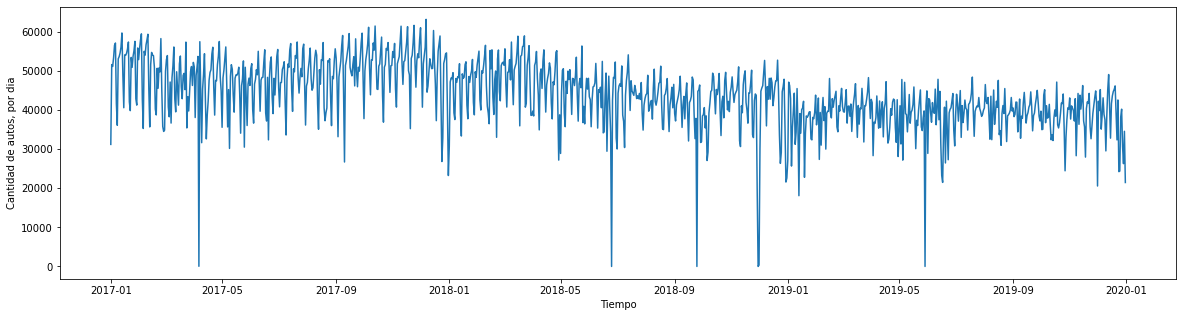

In [16]:
plt.figure(figsize = (20,5))
plt.plot(diario.index, diario.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')
plt.show()

## 1. Exploración de datos

Dedícale un buen tiempo a hacer un Análisis Exploratorio de Datos. Elige preguntas que creas que puedas responder con este dataset. Por ejemplo, ¿Cuáles son los días y horarios de mayor tráfico? También, estudia autocorrelaciones, resampleos, etc.

#### Componentes de la serie

1. Calcula las componentes estacionales y tendencia de la serie. Interpreta los resultados, si es necesario con información auxiliar (por fuera del dataset) o elementos del dataset que no estés utilizando (por ejemplo, si la tendencia es negativa, ¿puede ser porque se migre a otras formas de pago?).
1. ¿La serie posee valores atípicos? Si es así, interpreta, si es necesario con información auxiliar. **Pista**: primer semestre 2019.

## Descomposición Aditiva

### Se realiza una descomposición aditiva para obtener los componentes de tendencia y estacionalidad.

In [17]:
desc_add = seasonal_decompose(diario.cantidad_pasos, model='additive', extrapolate_trend='freq')

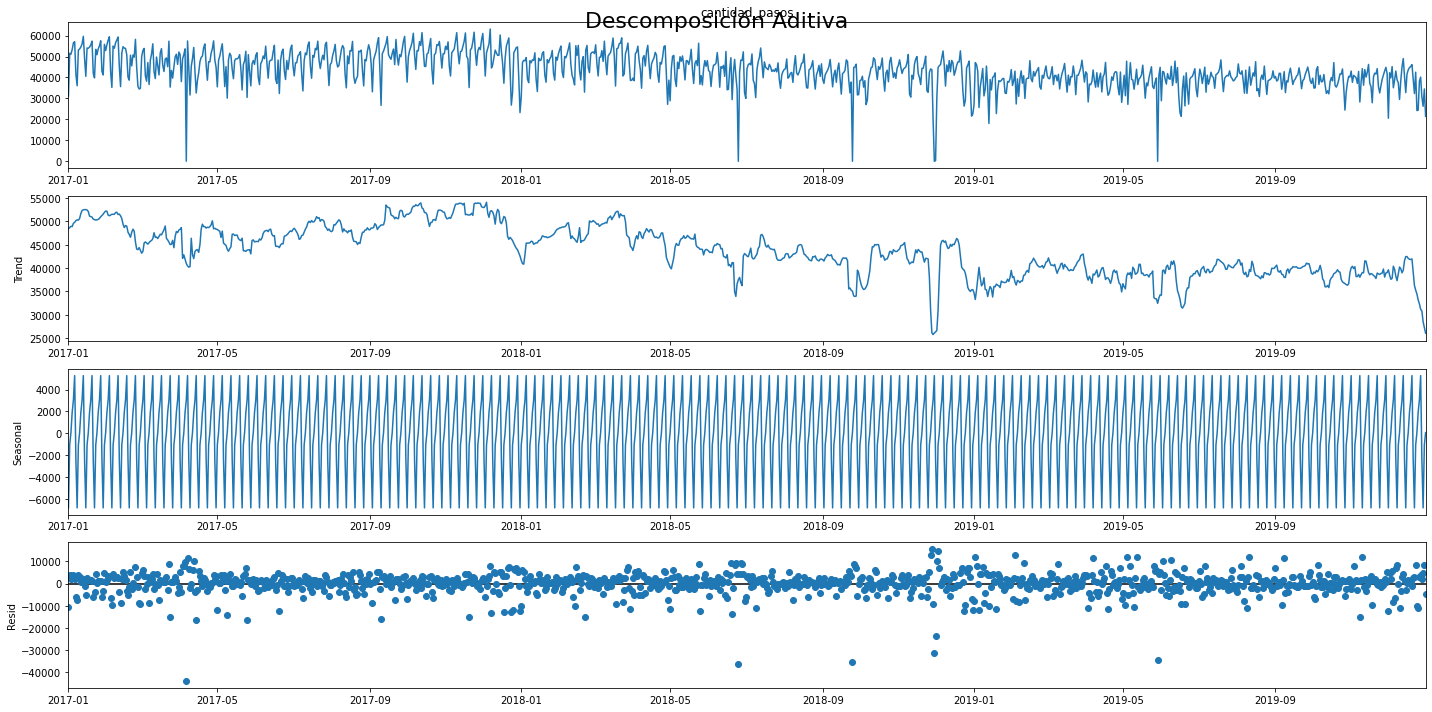

In [18]:
plt.rcParams.update({'figure.figsize': (20,10)})

desc_add.plot().suptitle('Descomposición Aditiva', fontsize=22)

plt.show()

Con la descomposición aditiva, se observa que la `tendencia` es negativa, el flujo vehicular va disminuyendo con el paso de los meses para la estación Illia y la forma de pago Efectivo. `

Se nota una `estacionalidad` marcada, los ciclos se van repitiendo en cada semana en el transcurso de los tres años.

In [19]:
df_add = pd.concat([desc_add.seasonal, desc_add.trend, desc_add.resid, desc_add.observed], axis=1)
df_add.columns = ['seas', 'trend', 'resid', 'actual_values']
df_add.head()

,seas,trend,resid,actual_values
fecha,,,,
2017-01-01,-6815.221907,48443.346939,-10445.125032,31183.0
2017-01-02,-1063.599295,48696.765306,3934.833989,51568.0
2017-01-03,67.228958,48950.183673,2075.587369,51093.0
2017-01-04,1911.562438,48904.285714,2516.151847,53332.0
2017-01-05,3048.398519,49601.714286,3835.887195,56486.0


### Se muestra que la serie tiene tendencia y estacionalidad, por lo que se puede concluir que la serie no es estacionaria, lo que significa que esas dos características afectarán sus valores en tiempos diferentes. Lo que se busca es que la serie sea estacionaria (Sin tendencia ni estacionalidad). 

Para corroborar que la serie es no estacionaria, se evaluará con las pruebas ADF (Augmented Dickey Fuller) y KPSS (Kwiatkowski-Phillips-Schmidt-Shin).

In [20]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss

In [21]:
## Prueba que identifica una diferencia estacionaria.
def adf_test(timeseries):
    print ('Prueba Dickey-Fuller:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

    statistic_value = dfoutput.loc['Test Statistic']
    if( statistic_value > dfoutput.loc['Critical Value (1%)'] or 
    statistic_value > dfoutput.loc['Critical Value (5%)'] or 
    statistic_value > dfoutput.loc['Critical Value (10%)'] ):
        print('\nPrueba ADF: No estacionaria')
    else:
        print('\nPrueba ADF: Es estacionaria')

## Prueba que identifica tendencia estacionaria.
def kpss_test(timeseries):
    print ('Prueba KPSS:')
    kpsstest = kpss(timeseries, regression='c')
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)

    statistic_value = kpss_output.loc['Test Statistic']
    if( statistic_value > kpss_output.loc['Critical Value (1%)'] or
    statistic_value > kpss_output.loc['Critical Value (2.5%)'] or
    statistic_value > kpss_output.loc['Critical Value (5%)'] or 
    statistic_value > kpss_output.loc['Critical Value (10%)'] ):
        print('\nPrueba KPSS: No estacionaria')
    else:
        print('\nPrueba KPSS: Es estacionaria')

In [22]:
# Se aplica la prueba adf a la serie
adf_test(diario['cantidad_pasos'])

Prueba Dickey-Fuller:
Test Statistic                   -2.185587
p-value                           0.211518
#Lags Used                       20.000000
Number of Observations Used    1074.000000
Critical Value (1%)              -3.436453
Critical Value (5%)              -2.864235
Critical Value (10%)             -2.568205
dtype: float64

Prueba ADF: No estacionaria


In [23]:
# Se aplica la prueba kpss a la serie
kpss_test(diario['cantidad_pasos'])

Prueba KPSS:
Test Statistic            3.724716
p-value                   0.010000
Lags Used                22.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64

Prueba KPSS: No estacionaria
C:\Users\ugom9\miniconda3\envs\Acamica-env\lib\site-packages\statsmodels\tsa\stattools.py:1850: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
C:\Users\ugom9\miniconda3\envs\Acamica-env\lib\site-packages\statsmodels\tsa\stattools.py:1882: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The 

Con las prueba se confirma que la serie es No Estacionaria, por lo que se necesitará un procesamiento para volverla Estacionaria.

Antes del procesamiento para volver estacionaria la serie, se realiza un análsis de los datos para la estación Illia con las diferentes modalidades de pago.

In [24]:
#Unimos los 3 datasets, podemos hacerlo asi directamente ya que tienen las mismas columnas
ds_Illia = pd.concat([data_2019, data_2018, data_2017])

#Nos quedamos solamente con la estación Illia
ds_Illia = ds_Illia[(ds_Illia.estacion=='Illia')]

#Quitamos las columnas que no vamos a utilizar
ds_Illia.drop(columns = ['periodo','hora_inicio','estacion'], inplace = True)

#Pasamos la columna fecha a formato datetime, y le unimos la hora_fin como hora
ds_Illia['fecha2'] = pd.to_datetime(ds_Illia.fecha) + pd.to_timedelta(ds_Illia.hora_fin, unit = 'h')

#Quitamos las columnas fecha y hora_fin ya que las incluimos en el campo fecha2
ds_Illia.drop(columns=['fecha','hora_fin'], inplace = True)

#Corregimos el nombre de fecha2 a fecha
ds_Illia.rename(columns = {'fecha2':'fecha'}, inplace = True) 

#Reordenamos el dataset por fecha
ds_Illia.sort_values('fecha', inplace = True)
ds_Illia.reset_index(drop=True, inplace = True)

ds_Illia.head()

,dia,sentido,tipo_vehiculo,forma_pago,cantidad_pasos,fecha
0,Domingo,Centro,Liviano,TELEPASE,459,2017-01-01
1,Domingo,Provincia,Pesado,TELEPASE,3,2017-01-01
2,Domingo,Provincia,Pesado,EFECTIVO,1,2017-01-01
3,Domingo,Provincia,Pesado,TELEPASE,7,2017-01-01
4,Domingo,Provincia,Pesado,EFECTIVO,6,2017-01-01


In [25]:
# Identificamos las modalidades de pago aceptadas en esta estación
ds_Illia['forma_pago'].unique()

array(['TELEPASE', 'EFECTIVO', 'EXENTO', 'INFRACCION',
       'TARJETA DISCAPACIDAD', 'NO COBRADO', 'MONEDERO',
       'T. DISCAPACIDAD'], dtype=object)

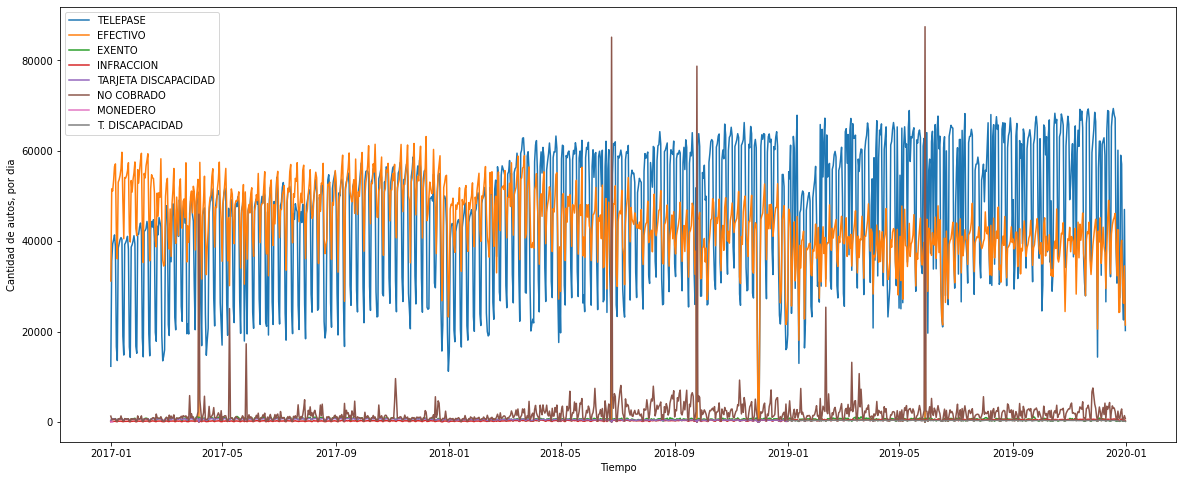

In [26]:
# Pintar gráfico del comportamiento de las modalidades de pago
plt.figure(figsize = (20,8))
for i in ds_Illia['forma_pago'].unique():
    diario_Illia = ds_Illia[(ds_Illia['forma_pago'] == i)].resample('D', on = 'fecha').sum()
    plt.plot(diario_Illia.index, diario_Illia.cantidad_pasos, label = i)
    plt.xlabel('Tiempo')
    plt.ylabel('Cantidad de autos, por dia')

plt.legend(loc="upper left")
plt.show()

Con base en el análisis de la gráfica anterior, la tendencia negativa para el flujo de vehículos con pago en Efectivo se debe a que los usuarios aparentemente comenzaron a optar por la modalidad de TelePase, dicha modalidad tiene un tendencia positva a la vez que la modalidad en Efectivo disminuye.

Otro punto a destacar es que los outliers en pago en Efectivo se presentan en los momentos pico de cuando los peajes no fueron cobrados. Esa es la razón por la cual están presentes, es esos días no se realizaron cobros en la estación.

# Autocorrelación

En la gráfica de la función de autocorrelación de la celda siguiente podemos notar una periodicidad marcada cada 7 días, con lo que podríamos asumir que el comportamiento del tráfico en un día es muy similar al de 7 días antes. Por ejemplo, todos los lunes tendrán un comportamiento similiar, es algo que sabemos de antemano pero aquí lo confirmamos. 

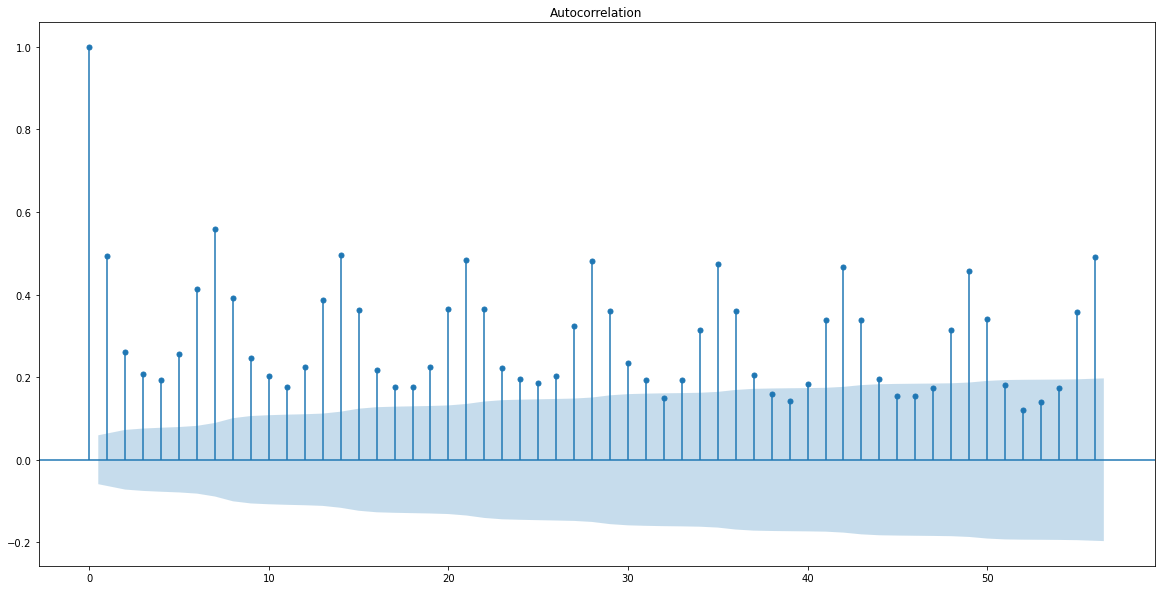

In [27]:
nlags =  7*8 # 8 semanas

plot_acf(diario.cantidad_pasos, lags = nlags)
plt.show()

## 2. Predicción a Futuro

Debes implementar un modelo que prediga el tráfico en la autopista Illia para el último trimestre del 2019. 

1. Haz todas las transformaciones de datos que consideres necesarias. Justifica.
1. Evalúa de forma apropiada tus resultados. Justifica la métrica elegida.
1. Elige un modelo benchmark y compara tus resultados con este modelo.
1. Optimiza los hiperparámetros de tu modelo. 
1. Intenta responder la pregunta: ¿Qué información está usando el modelo para predecir?
1. Utiliza el modelo creado para predecir el tráfico en el año 2020. ¿Cómo funciona?

### 2.1 Haz todas las transformaciones de datos que consideres necesarias. Justifica.

In [28]:
diario.cantidad_pasos.head(7)

fecha
2017-01-01    31183
2017-01-02    51568
2017-01-03    51093
2017-01-04    53332
2017-01-05    56486
2017-01-06    57081
2017-01-07    41587
Freq: D, Name: cantidad_pasos, dtype: int64

### Eliminar tendencia y estacionalidad

In [29]:
senial = diario.cantidad_pasos - df_add.trend - df_add.seas 
senial.head()

fecha
2017-01-01   -10445.125032
2017-01-02     3934.833989
2017-01-03     2075.587369
2017-01-04     2516.151847
2017-01-05     3835.887195
Freq: D, dtype: float64

In [30]:
adf_test(senial)

Prueba Dickey-Fuller:
Test Statistic                -1.374056e+01
p-value                        1.096409e-25
#Lags Used                     2.200000e+01
Number of Observations Used    1.072000e+03
Critical Value (1%)           -3.436465e+00
Critical Value (5%)           -2.864240e+00
Critical Value (10%)          -2.568208e+00
dtype: float64

Prueba ADF: Es estacionaria


In [31]:
kpss_test(senial)

Prueba KPSS:
Test Statistic            0.030389
p-value                   0.100000
Lags Used                22.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64

Prueba KPSS: Es estacionaria
C:\Users\ugom9\miniconda3\envs\Acamica-env\lib\site-packages\statsmodels\tsa\stattools.py:1850: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
C:\Users\ugom9\miniconda3\envs\Acamica-env\lib\site-packages\statsmodels\tsa\stattools.py:1886: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The 

### Crear ventanas de datos

In [32]:
# Función que crea una ventana de datos por instancia. Se indica la cantidad de datos que se utilizarán para predecir, la cantidad de valores a predecir y el retraso
def crearVentana(input_width, label_width, shift, data):

    total_window_size = input_width + shift
    label_start = total_window_size - label_width

    input_slice = slice(0, input_width)
    labels_slice = slice(label_start, label_start + label_width)

    data = np.array(data, dtype=np.float32)
    inputs = data[input_slice]
    labels = data[labels_slice]
    return inputs, labels

# Funcion que crea el set de datos completo considerando la características de la ventana deseada
def crearDataSetSupervisado(input_width, label_width, shift, data):
    N = data.shape[0]
    X = np.zeros((N - input_width - shift, input_width))
    y = np.zeros((N - input_width - shift, label_width))

    for i in range(X.shape[0]):
        X[i,:], y[i] = crearVentana(input_width, label_width, shift, data[slice(i, None)])

    return X, y

In [33]:
input_width = 7 # Entradas para realizar la predición (Tomamos 7 dias)
label_width = 1 # Cantidad de días-horas a predecir
shift = 1 # Cantidad de días-horas en el futuro ( > 0)

X, y = crearDataSetSupervisado(input_width = input_width, label_width  = label_width, shift = shift, data = senial)
print(X.shape, y.shape)

(1087, 7) (1087, 1)


### Preparar conjuntos de entrenamiento y prueba

In [34]:
N = len(X)

N_train = int(N*0.9) # Cantidad de instancias que vamos a usar para entrenar. 
N_test = N - N_train # El restante son los meses a predecir (3 últimos meses del 2019)

length_total = N_train + N_test + input_width

X_train = X[:N_train,:]
y_train = y[:N_train]
print(X_train.shape, y_train.shape)

X_test = X[N_train:N_train+N_test,:]
y_test = y[N_train:N_train+N_test]
print(X_test.shape, y_test.shape)

(978, 7) (978, 1)
(109, 7) (109, 1)


### 2.2 Evalúa de forma apropiada tus resultados. Justifica la métrica elegida.

**Métrica de evaluación seleccionada.**

* `Error Absoluto Medio (MAE)` 

En este caso se selecciona el MAE como métrica debido a que en el caso de que se presente algún error considerable en las predicciones, este no será acentuado como prodría suceder con el Error Cuadrático Medio (RMSE), por lo que se podrá hacer una evaluación más objetiva.

### 2.3 Elige un modelo benchmark y compara tus resultados con este modelo.

**Modelo benchmark seleccionao**

* `XGBRegressor` con hiperparámetros por defecto

### One-Step Prediction (XGBRegressor)

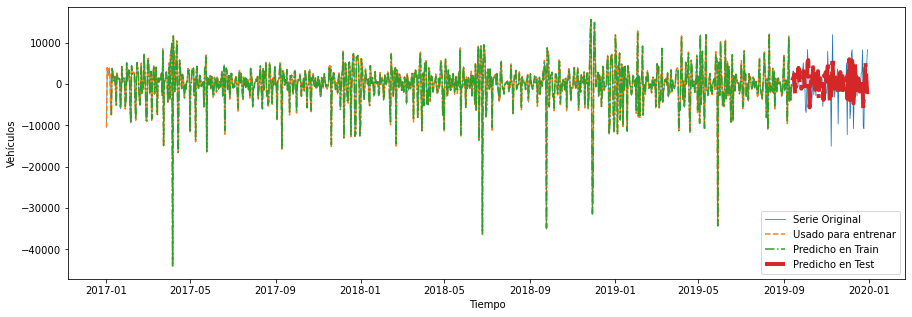

In [35]:
xgb = XGBRegressor(random_state=42, n_jobs = -1).fit(X_train,y_train)

y_pred = xgb.predict(X)
y_train_pred = xgb.predict(X_train)
y_test_pred = xgb.predict(X_test)

plt.figure(figsize=(15,5))
plt.plot(senial.index[:length_total], senial[:length_total],lw = 0.75, label = 'Serie Original')
plt.plot(senial.index[:N_train + input_width], senial[:N_train + input_width],'--', label = 'Usado para entrenar')
plt.plot(senial.index[input_width: input_width + N_train], y_train_pred,'-.',label = 'Predicho en Train')
plt.plot(senial.index[N_train+input_width: length_total], y_test_pred,'-.', lw = 4, label = 'Predicho en Test')
plt.legend()
plt.xlabel('Tiempo')
plt.ylabel('Vehículos')
plt.show()

In [36]:
MAE_train = mean_absolute_error(y_train, y_train_pred)
print('Error en Train:',MAE_train)

MAE_test = mean_absolute_error(y_test, y_test_pred)
print('Error en Test:',MAE_test)

Error en Train: 153.60102240939327
Error en Test: 2618.728078474692


### 2.4 Optimiza los hiperparámetros de tu modelo. 

In [37]:
from sklearn.model_selection import ParameterGrid

#### XGB Regressor

**Hiperparámetros optimizados:**

- `n_estimators` : Para que el modelo pueda ser más adaptable a la cantidad de datos.
- `learning_rate` : Para regular la taza de aprendizage y pueda realizar un ajuste más "fino".
- `reg_lambda` : Para evitar sobreajuste que pueda provocar el learning_rate.

In [38]:
params_grid = {
              'n_estimators': np.arange(500,2000,100),
              'n_jobs' : [-1], # Ocupa todos los nucleos de la CPU        
              'learning_rate': np.arange(1,5,2)/1000, 
              'reg_lambda':np.arange(1,5,2)/10000
              }

grid = ParameterGrid(params_grid)

print('Número de posibles modelos:',len(grid))

Número de posibles modelos: 60


In [39]:
%%time
grid_keys = list( params_grid.keys() )
grid_keys.extend(['MAE_train','MAE_test'])

MAE_grid = pd.DataFrame(columns = grid_keys)

for param in grid:

    model = XGBRegressor()
    model.set_params(**param)
    model.fit(X_train,y_train)

    y_pred = model.predict(X)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    MAE_train = mean_absolute_error(y_train, y_train_pred)
    MAE_test = mean_absolute_error(y_test, y_test_pred)

    values = param
    values['MAE_train'] = MAE_train
    values['MAE_test'] = MAE_test

    MAE_grid = MAE_grid.append(values, ignore_index=True)

MAE_grid.sort_values('MAE_test').head()

Wall time: 2min


,n_estimators,n_jobs,learning_rate,reg_lambda,MAE_train,MAE_test
59,1900.0,-1.0,0.003,0.0003,1173.136018,2383.112325
57,1800.0,-1.0,0.003,0.0003,1209.565993,2389.585176
58,1900.0,-1.0,0.003,0.0001,1169.893596,2399.810281
55,1700.0,-1.0,0.003,0.0003,1246.694783,2401.445079
56,1800.0,-1.0,0.003,0.0001,1212.387219,2405.972890


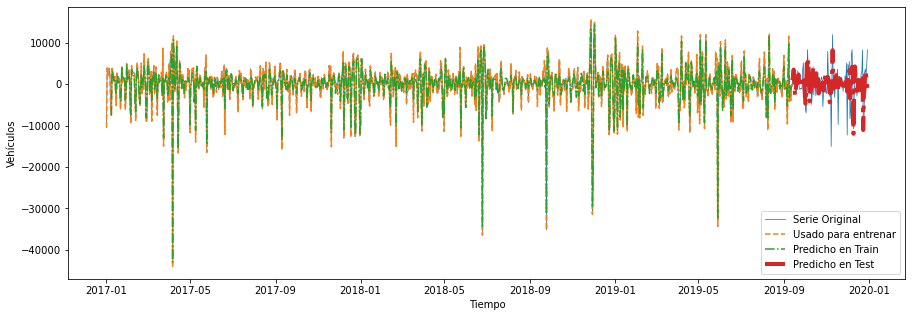

In [40]:
xgb = XGBRegressor()
xgb.set_params(**grid[59]) # Considerando los parámetros con mejor rendimiento del grid
xgb.fit(X_train,y_train)

y_pred = xgb.predict(X)
y_train_pred = xgb.predict(X_train)
y_test_pred = xgb.predict(X_test)

plt.figure(figsize=(15,5))
plt.plot(senial.index[:length_total], senial[:length_total],lw = 0.75, label = 'Serie Original')
plt.plot(senial.index[:N_train + input_width], senial[:N_train + input_width],'--', label = 'Usado para entrenar')
plt.plot(senial.index[input_width: input_width + N_train], y_train_pred,'-.',label = 'Predicho en Train')
plt.plot(senial.index[N_train+input_width: length_total], y_test_pred,'-.', lw = 4, label = 'Predicho en Test')
plt.legend()
plt.xlabel('Tiempo')
plt.ylabel('Vehículos')
plt.show()

In [41]:
MAE_train = mean_absolute_error(y_train, y_train_pred)
print('Error en Train:',MAE_train)

MAE_test = mean_absolute_error(y_test, y_test_pred)
print('Error en Test:',MAE_test)

Error en Train: 1173.1360184499092
Error en Test: 2383.112324797779


Con la optimización de hiperparámetros, el modelo mejoró ligeramente su desempeño, pasó de MAE = 2618.728 a MAE = 2383.112, lo que indica que posiblemente su desempeño actual se debe a que hace falta agregar mas features para que realice predicciones más precisas.

Considero importante señalar que realicé varias iteraciones para la optimización de hiperparámetros, las cuales me llevaron varios días por la demanda computacional que implicaban, y aún así llegué a resultados muy similares, por lo que para fines de entrega de la bitácora, sólo considero las optimización de los hiperparámetros presentes.

### 2.5 Intenta responder la pregunta: ¿Qué información está usando el modelo para predecir?

Para el desarrollo del modelo se utilizan como features los datos de los 7 dias anteriores a la fecha que se quiere predecir.
Por ejemplo, si queremos predecir para el día lunes 22 de febrero del 2021, los datos a utilizar para hacerlo son del día lunes 15 de febrero al domingo 21.

Teniendo eso en cuenta, en el gráfico de la siguiente celda podemos observar que el dato con más importancia, y por mucho, es el que corresponde al mismo día pero de la semana anterior, o sea, si estámos por predecir el valor para un día lunes, será más importante  para el modelo el valor del día lunes de la semana anterior para poder predecir, y así con los demás días.

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

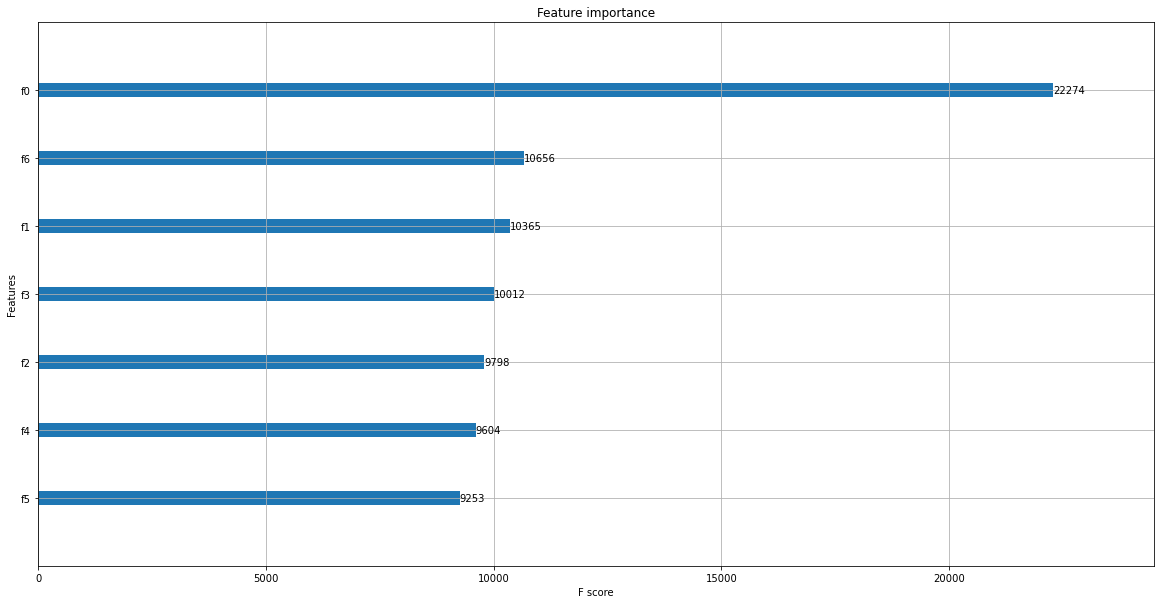

In [42]:
plot_importance(xgb)

### 2.6 Utiliza el modelo creado para predecir el tráfico en el año 2020. ¿Cómo funciona?

In [43]:
# Utilizaremos el modelo ya entrenado para predecir los valores para los 366 días del 2020 (año bisiesto)
N_2020 = 366
X_2020 = np.zeros((N_2020 - input_width - shift, input_width))
y_2020 = np.zeros((N_2020 - input_width - shift, label_width))

senial_2020_pred = senial[-7:] # Tomamos los últimos 7 días del 2019 para realizar la predicción del 1/01/2020

y_ms_test_pred = []
X_ms_test = []

length_total = N_2020

for i in range(length_total):
    x = np.array(senial_2020_pred[i:], dtype=np.float32)
    X_ms_test.append(x)
    
    y_pred = xgb.predict(x.reshape(1,-1))
    y_ms_test_pred.append(y_pred)
    
    idx = senial_2020_pred.index[-1] + pd.Timedelta(days=1)
    senial_2020_pred = senial_2020_pred.append(pd.Series(y_pred, index=[idx])) # Guardamos cada predicción realizada para 2020

y_ms_test_pred = np.array(y_ms_test_pred)

In [44]:
senial_2020_pred

2019-12-25   -10772.276724
2019-12-26     2778.172910
2019-12-27     3708.365217
2019-12-28     2304.289210
2019-12-29     4580.941295
                  ...     
2020-12-27      -31.878698
2020-12-28      238.168060
2020-12-29      430.570190
2020-12-30      -82.337502
2020-12-31     -226.798721
Length: 373, dtype: float64

In [45]:
# Preparamos el dataset con los valores reales por día del 2020 para evaluar los resultados de la predicción
dataset_2020 = pd.read_csv('Datasets//flujo-vehicular-2020.csv', sep =',')

#Nos quedamos solamente con la estación Illia y la forma de pago Efectivo
mask = np.logical_and(dataset_2020.estacion=='ILLIA', dataset_2020.forma_pago == 'Efectivo')
dataset_2020 = dataset_2020[mask]

#Quitamos las columnas que no vamos a utilizar
dataset_2020.drop(columns = ['periodo','hora_inicio','forma_pago', 'estacion','dia_fecha'], inplace = True)

#Pasamos la columna fecha a formato datetime, y le unimos la hora_fin como hora
dataset_2020['fecha2'] = pd.to_datetime(dataset_2020.fecha) + pd.to_timedelta(dataset_2020.hora_fin, unit = 'h')

#Quitamos las columnas fecha y hora_fin ya que las incluimos en el campo fecha2
dataset_2020.drop(columns=['fecha','hora_fin'], inplace = True)

#Corregimos el nombre de fecha2 a fecha
dataset_2020.rename(columns = {'fecha2':'fecha'}, inplace = True) 

#Reordenamos el dataset por fecha
dataset_2020.sort_values('fecha', inplace = True)
dataset_2020.reset_index(drop=True, inplace = True)

diario_2020 = dataset_2020.resample('D', on = 'fecha').sum()

diario_2020.head()

,cantidad_pasos
fecha,
2020-01-01,21395.0
2020-01-02,33722.0
2020-01-03,37067.0
2020-01-04,30627.0
2020-01-05,27812.0


In [46]:
# Realizamos la conversión para volver estacionaría la serie del 2020, eliminando la componente de tendencia y estacionalidad
desc_add_2020 = seasonal_decompose(diario_2020.cantidad_pasos, model='additive', extrapolate_trend='freq')

df_add_2020 = pd.concat([desc_add_2020.seasonal, desc_add_2020.trend, desc_add_2020.resid, desc_add_2020.observed], axis=1)
df_add_2020.columns = ['seas', 'trend', 'resid', 'actual_values']

senial_2020 = diario_2020.cantidad_pasos - df_add_2020.trend - df_add_2020.seas 
senial_2020.head()

senial_2020.head()

fecha
2020-01-01   -10318.164945
2020-01-02     1041.532494
2020-01-03     2784.751274
2020-01-04     1215.717522
2020-01-05    -1380.092917
Freq: D, dtype: float64

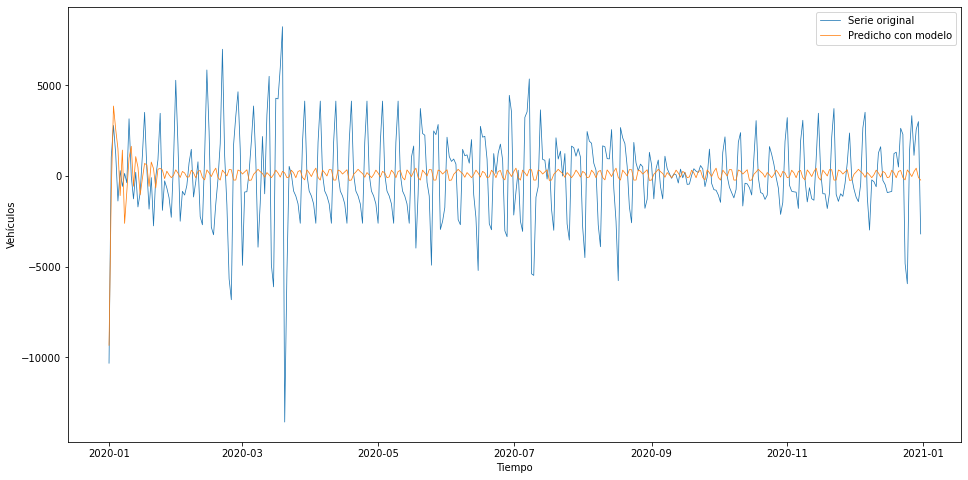

In [47]:
# Trazamos las gráficas para hacer una comparación visual de la predicción y los valores reales
plt.figure(figsize=(16,8))
plt.plot(senial_2020.index, senial_2020,lw = 0.75, label = 'Serie original')
plt.plot(senial_2020.index, y_ms_test_pred,lw = 0.75, label = 'Predicho con modelo')
plt.legend()
plt.xlabel('Tiempo')
plt.ylabel('Vehículos')
plt.show()

In [48]:
# Obtenemos el MAE para una evaluación cuantitativa.
MAE_test = mean_absolute_error(senial_2020, y_ms_test_pred)
print('MAE para predicción 2020:',MAE_test)

MAE para predicción 2020: 1833.0122688288025


### ¿Cómo funciona el modelo?

Basados en las evaluaciones visuales y con el MAE, se percibe que el modelo no se desempeña muy bien ya que los valores predichos distan por mucho de los valores reales. La diferencia es muy notoría.

Este comportamiento es esperado ya que únicamente se utilizaron como features los valores de los 7 días anteriores para predecir, por lo que el modelo "tiene un idea" de lo que podría suceder, y tampoco se desempeña tan mal, pero puede mejorar considerando más features para realizar la predicción.

## 3. Para pensar, investigar y, opcionalmente, implementar

### 3.1 ¿Cómo incorporarías la información sobre tipo de vehículo, forma de pago, sentido, día de la semana, etc.? En lo que respecta a las predicciones, ¿mejoran o empeoran?

Los incorporaría como features junto con los valores de los 7 dias anteriores al target, aplicando One-Hot Encoding para los casos que apliquen. Definitivamente considero que mejoraría mucho el desempeño. El objetivo es realizar este ejercicio para el Proyecto 4.

### 3.2 ¿Qué ocurre si comparas las series de tiempo entre distintas estaciones de peajes?¿Tienen el mismo comportamiento o hay alguna que sea distinta a las otras? Si es así, ¿hay información auxiliar que te ayude a explicar lo que encuentras?

Podrían tener las mismas tendencias, aunque en diferente escala, ya que por lo general el flujo vehicular va en aumento. Otra cosa que también podríamos notar es que la gente migra a la modalidad de Telepase, pero se tendrían que considerar varios casos y escenarios para hacer una revisión más detalla. Y considero que contamos con la información suficiente para hacer un buen análisis.

### 3.3 ¿Hay algo que te gustaría investigar o probar?

Lo que me gustaría implementar, y estoy decidido a hacer para el proyecto 4, es lo comentado en la pregunta 3.1, agregar más features para entrenar el modelo y tratar de mejorar su desempeño.

Link al repositorio: https://github.com/ugom93/Acamica/blob/main/DS_Proyecto_03_ST.ipynb